In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Emo/fer2013.csv')

In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert pixels into an array
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)

# Convert grayscale images to RGB
img_features = []
for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)
img_features = np.array(img_features)

# Encode labels and convert to categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)


In [ ]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle=True,
                                                      stratify=img_labels,
                                                      test_size=0.1,
                                                      random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [ ]:
# Define VGG19 base model
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Build the model
def build_model(bottom_model, classes):
    model = bottom_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation='softmax', name='output_layer')(model)
    return model

#The function expects an argument called classes not num_classes
head = build_model(vgg, classes=y_train.shape[1])
model = Model(inputs=vgg.input, outputs=head)

In [ ]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=11, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7)
callbacks = [early_stopping, lr_scheduler]

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.15, height_shift_range=0.15,
                                   shear_range=0.15, zoom_range=0.15, horizontal_flip=True)
train_datagen.fit(X_train)

In [ ]:
# Training the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    callbacks=callbacks)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - accuracy: 0.3430 - loss: 1.6280 - val_accuracy: 0.5093 - val_loss: 1.3071 - learning_rate: 1.0000e-04
Epoch 2/50
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.5625 - loss: 1.3177

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.3177 - val_accuracy: 0.5185 - val_loss: 1.2821 - learning_rate: 1.0000e-04
Epoch 3/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 68s 67ms/step - accuracy: 0.5132 - loss: 1.2660 - val_accuracy: 0.5559 - val_loss: 1.1926 - learning_rate: 1.0000e-04
Epoch 4/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3750 - loss: 1.6833 - val_accuracy: 0.5598 - val_loss: 1.1843 - learning_rate: 1.0000e-04
Epoch 5/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - accuracy: 0.5595 - loss: 1.1643 - val_accuracy: 0.5868 - val_loss: 1.1194 - learning_rate: 1.0000e-04
Epoch 6/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.0823 - val_accuracy: 0.5821 - val_loss: 1.1287 - learning_rate: 1.0000e-04
Epoch 7/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - accuracy: 0.5821 - loss: 1.1025 - val_accuracy: 0.6077 - val_loss: 1.0496 - learning_rate: 1.0000e-04
Epoch 8/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - a

In [ ]:
val_acc = history.history['val_accuracy']
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


Final Validation Accuracy: 0.6879


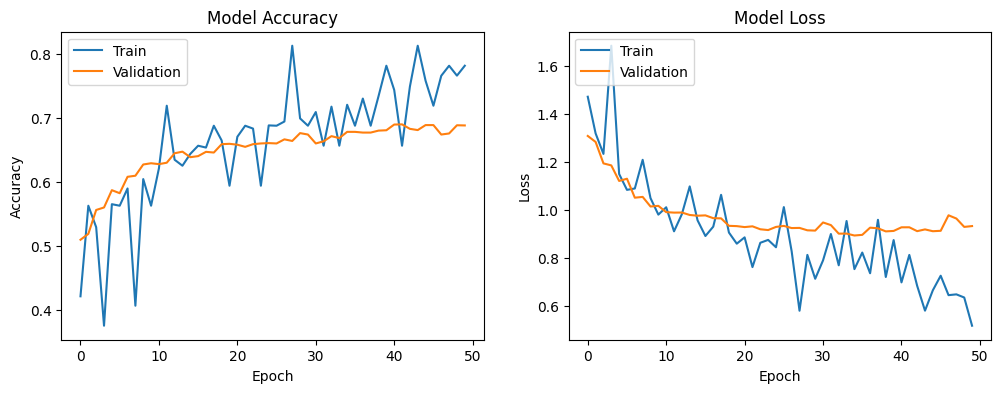

In [ ]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Predictions on the validation set
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [ ]:
# Classification Report
class_labels = ["anger", "disgust", "fear", "happiness", "sadness", "surprise", "neutral"]
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       anger       0.61      0.63      0.62       495
     disgust       0.82      0.33      0.47        55
        fear       0.65      0.41      0.50       512
   happiness       0.89      0.87      0.88       899
     sadness       0.60      0.52      0.56       608
    surprise       0.79      0.80      0.80       400
     neutral       0.55      0.83      0.66       620

    accuracy                           0.69      3589
   macro avg       0.70      0.63      0.64      3589
weighted avg       0.70      0.69      0.68      3589



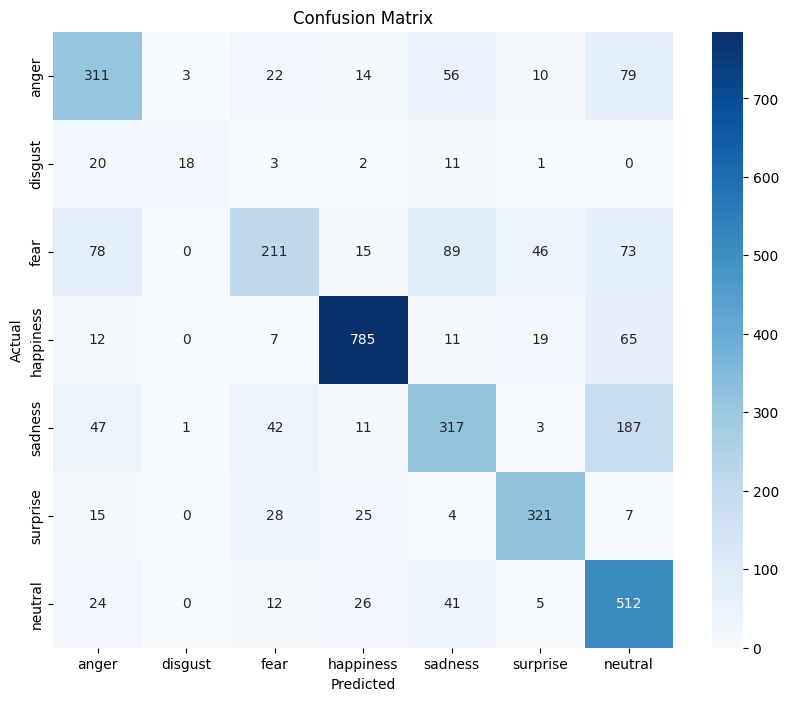

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


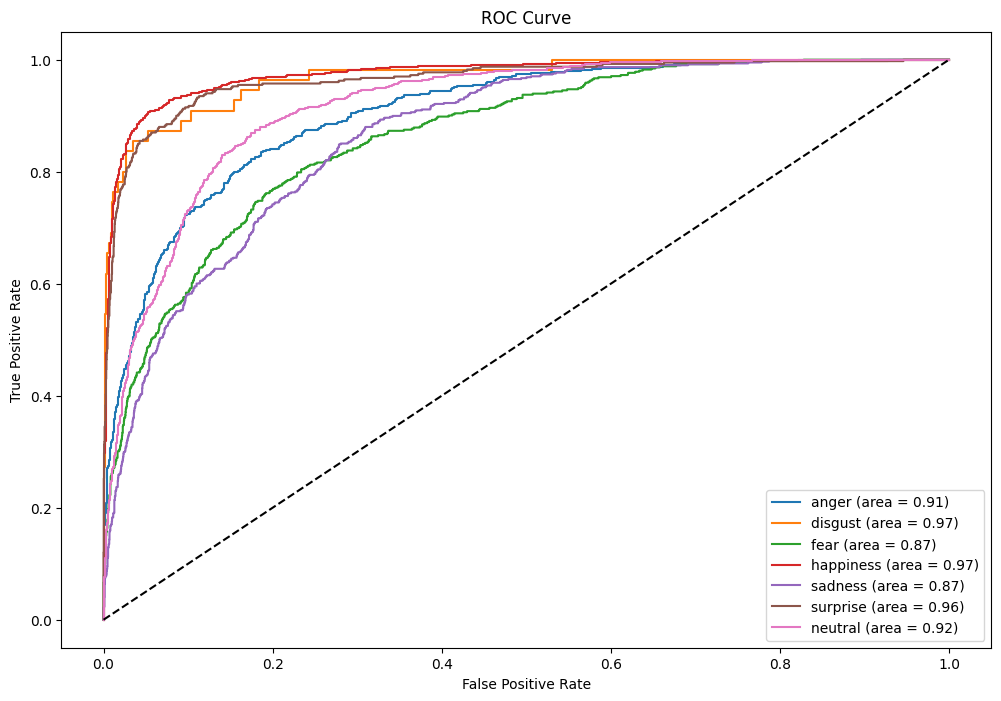

In [ ]:
# ROC-PR Curve
plt.figure(figsize=(12, 8))
for i in range(7):
    fpr, tpr, _ = roc_curve(y_valid[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (area = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Save model weights with the correct extension to the specified path
model.save_weights('/content/drive/MyDrive/Emo/vgg19_fer2013_weights.weights.h5')


In [ ]:
import os

In [ ]:
# Load the model weights from the specified path
model.load_weights('/content/drive/MyDrive/Emo/vgg19_fer2013_weights.weights.h5')


In [ ]:
class_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


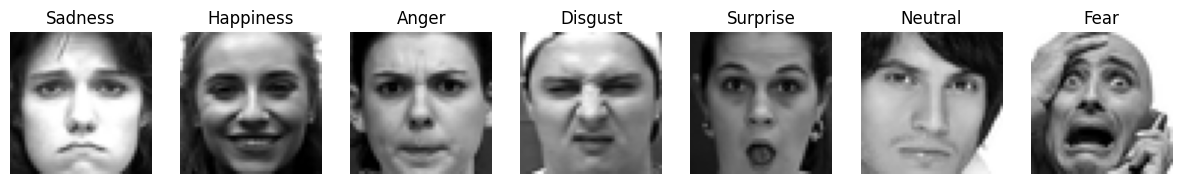

In [ ]:
def predict_emotion(image):
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:  # If the image is grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Resize image to the required size
    image = cv2.resize(image, (48, 48))
    # Normalize the image
    image = image.astype('float32') / 255.0
    # Expand dimensions to match model input
    image = np.expand_dims(image, axis=0)
    # Predict emotion
    pred = model.predict(image)
    # Return the label of the highest probability
    return class_labels[np.argmax(pred)]

def predict_from_folder(folder_path):
    results = {}
    # List all files in the folder
    for filename in os.listdir(folder_path):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        # Load the image
        image = cv2.imread(file_path)
        if image is not None:
            # Predict emotion
            emotion = predict_emotion(image)
            # Save the result
            results[filename] = (emotion, image)
        else:
            print(f"Warning: Could not load image {file_path}")
    return results

def plot_images_with_predictions(results):
    plt.figure(figsize=(15, 15))
    for i, (filename, (emotion, image)) in enumerate(results.items()):
        plt.subplot(1, len(results), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(emotion)
        plt.axis('off')
    plt.show()

# Path to your test images folder
folder_path = '/content/drive/MyDrive/Emo/test'

# Get predictions
predictions = predict_from_folder(folder_path)

# Plot the images with predictions
plot_images_with_predictions(predictions)
